In [11]:
using DifferentialEquations, Plots, LinearAlgebra, LaTeXStrings
include("utils.jl")

animate_trajectory (generic function with 1 method)

# Geodésicas en Kerr

## Plano ecuatorial

Por el momento sólo tomemos en cuenta el plano ecuatorial $\theta = \pi/2$, en ese caso la métrica es

$$ ds^{2} = -\left( 1 - \dfrac{2M}{r} \right)dt^{2} - \dfrac{4aM}{r}dtd\varphi + \dfrac{r^{2}}{\Delta}dr^{2} + \left( r^{2} + a^{2} + \dfrac{2Ma^{2}}{r} \right)d\varphi^{2}. $$

Las órbitas están en términos de las cantidades conservadas: la energía $\varepsilon$ y el momento angular $\ell$ (a lo largo del eje de simetría) de la partícula, las cuales surgen de la independencia de $t$ y $\varphi$ de la métrica. En términos de los vectores de Killing $\boldsymbol{\xi}$, $\boldsymbol{\eta}$ y la 4-velocidad $\boldsymbol{u}$ se tiene que 

\begin{align*}
\varepsilon &= - \boldsymbol{\xi}\cdot\boldsymbol{u}, \\
\ell &= \boldsymbol{\eta}\cdot\boldsymbol{u}.
\end{align*}



Las ecuaciones de la geodésica para el caso de Schwarzschild son

\begin{align}
\dfrac{d^2 t}{d\lambda^2} &= \dfrac{2M}{2Mr - r^2} \left( \dfrac{dt}{d\lambda} \right) \left( \dfrac{dr}{d\lambda} \right), \\
\dfrac{d^2 r}{d\lambda^2} &= \dfrac{M(2M-r)}{r^3} \left( \dfrac{dt}{d\lambda} \right)^{2} - \dfrac{M}{2Mr - r^2} \left( \dfrac{dr}{d\lambda} \right)^{2} - (2M - r) \left( \dfrac{d\theta}{d\lambda} \right)^{2} - (2M - r)\sin^{2}\theta \left( \dfrac{d\phi}{d\lambda} \right)^{2}, \\
\dfrac{d^2 \theta}{d\lambda^2} &= - \dfrac{2}{r} \left( \dfrac{dr}{d\lambda} \right) \left( \dfrac{d\theta}{d\lambda} \right) + \cos\theta\sin\theta \left( \dfrac{d\phi}{d\lambda} \right)^{2}, \\
\dfrac{d^2 \phi}{d\lambda^2} &= -\dfrac{2}{r} \left( \left( \dfrac{dr}{d\lambda} \right) + r\cot\theta \left( \dfrac{d\theta}{d\lambda} \right) \right) \left( \dfrac{d\phi}{d\lambda} \right).
\end{align}

Tomando $\theta = \pi / 2$ y considerando las cantidades conservadas $\ell = r^{2}\sin^{2}\theta \frac{d\phi}{d\lambda}$, $\epsilon = \left(1-\frac{2M}{r}\right)\frac{dt}{d\lambda}$ las ecuaciones para $r$ y $\phi$ quedan

\begin{align}
\dfrac{d^2 r}{d\lambda^2} &= -\dfrac{M\epsilon^2}{r^2}\left( 1 - \dfrac{2M}{r}\right)^{-1} - \dfrac{M}{2Mr - r^2} \left( \dfrac{dr}{d\lambda} \right)^{2} + \left( 1 - \dfrac{2M}{r}\right)\dfrac{\ell^{2}}{r^3},\\
\dfrac{d^2 \phi}{d\lambda^2} &= -\dfrac{2}{r}\dfrac{dr}{d\lambda}\dfrac{d\phi}{d\lambda}.
\end{align}

O usando $\ell$ en la ecuación de $\theta$

\begin{align}
\dfrac{d^2 r}{d\lambda^2} &= -\dfrac{M\epsilon^2}{r^2}\left( 1 - \dfrac{2M}{r}\right)^{-1} - \dfrac{M}{2Mr - r^2} \left( \dfrac{dr}{d\lambda} \right)^{2} + \left( 1 - \dfrac{2M}{r}\right)\dfrac{\ell^{2}}{r^3},\\
\dfrac{d\phi}{d\lambda} &= \dfrac{\ell}{r^2}.
\end{align}

In [12]:
function Δ(r,p)
    M, a, ϵ, b, ℓ = p
    return r^2 - 2*M*r + a^2
end

function dt_dλ(r, p)
    M, a, ϵ, b, ℓ = p
    return ((r^2 + a^2 + (2*M*a^2)/r)*ϵ - 2*M*a*ℓ/r)/Δ(r,p)
end
    
function dϕ_dλ(r, p)
    M, a, ϵ, b, ℓ = p
    return (ℓ*(1 - 2*M/r) + 2*M*a*ϵ/r)/Δ(r,p)
end

dϕ_dλ (generic function with 1 method)

In [13]:
function parameterized_kerr!(du, u, p, t)    
    """
    Parameters
    ----------
    du: variable auxiliar de ODEProblem
    u: vector con las variables (r'=dr/dλ, r, ϕ) 
    p: un vector con los parámetros del agujero [M, ϵ, b, ℓ]
    """
    r′, r, ϕ = u
    M, a, ϵ, b, ℓ = p
    σ = sign(ℓ)
      
    # Primer intento con la ecuación del potencial efectivo
    # du[1] = dr′ = -(ℓ/(2*r′))*2*((b^2*(3*M - r) - 6*a*b*M*σ + a^2*(r + 3*M*σ^2))/(b^2 * r^4))
    
    du[1] = dr′ = ((r^5 * (r′)^2 * (M*r - a^2))/(a^2 + r*(r - 2*M)) + r^2*(a^2 + r*(r - 2*M))*(-M*(dt_dλ(r,p))^2 + 2*a*M*dt_dλ(r,p)*dϕ_dλ(r,p) + (-a^2*M + r^3)*(dϕ_dλ(r,p))^2))/r^6
    du[2] = dr = r′
    du[3] = dϕ = (ℓ*(1 - 2*M/r) + 2*M*a*ϵ/r)/(r^2 - 2*M*r + a^2)
    
end

parameterized_kerr! (generic function with 1 method)

In [14]:
function geodesics_kerr(p, r0, ϕ0, λ_final, dλ_min, dλ_max=2*dλ_min)
    """
    Parameters
    ----------
    p: un vector con los parámetros del agujero [M, ϵ, b, ℓ]
    r0: radio inicial
    ϕ0: ángulo inicial
    λ_final: número de 'steps'
    dλ_min: tamaño del 'step'
    """
       
    M, a, ϵ, b, ℓ = p
    
    if a > M
        println("Error: a > M")
        return 
    end
    
    Δ0 = Δ(r0, p)
    dt0_dλ = dt_dλ(r0, p)
    dϕ0_dλ = dϕ_dλ(r0, p)
    
    r′0 = -sqrt((Δ0/r0^2)*((1-2*M/r0)*dt0_dλ^2 + (4*a*M/r0)*dt0_dλ*dϕ0_dλ - (r0^2 + a^2 + (2*M*a^2)/r0)*dϕ0_dλ^2))
    tspan = (0.0, λ_final)
    
    u0 = [r′0, r0, ϕ0]  
    
    prob = ODEProblem(parameterized_kerr!, u0, tspan, p)
    sol = solve(prob, dtmin=dλ_min, dtmax=dλ_max, force_dtmin=true);
    
    r′s, rs, ϕs = sol[1,:], sol[2,:], sol[3,:]
    
    xs = [rs[i]*cos(ϕs[i]) for i in 1:length(sol)]   
    ys = [rs[i]*sin(ϕs[i]) for i in 1:length(sol)] 
    ds = [-(1 - 2*M/rs[i])*(dt_dλ(rs[i], p))^2 - (4*a*M/rs[i])*dt_dλ(rs[i], p)*dϕ_dλ(rs[i], p) + 
          (rs[i]^2/Δ(rs[i],p))*(r′s[i])^2 + (rs[i]^2 + a^2 + 2*M*a^2/rs[i])*(dϕ_dλ(rs[i], p))^2 for i in 1:length(rs)]
    
    return xs, ys, rs, ds
    
end

geodesics_kerr (generic function with 2 methods)

Se debería recuperar Schwarzschild haciendo $a=0$, lo que en efecto sucede.

  0.075460 seconds (500.60 k allocations: 56.028 MiB, 17.69% gc time)
maximum(abs.(ds)) = 4.315992008230296e-15


┌ Info: Saved animation to 
│   fn = /home/david/Documentos/Física/Servicio/Servicio-Github/Notebooks/Kerr/n3.gif
└ @ Plots /home/david/.julia/packages/Plots/qZHsp/src/animation.jl:98


Plots.AnimatedGif("/home/david/Documentos/Física/Servicio/Servicio-Github/Notebooks/Kerr/n3.gif")
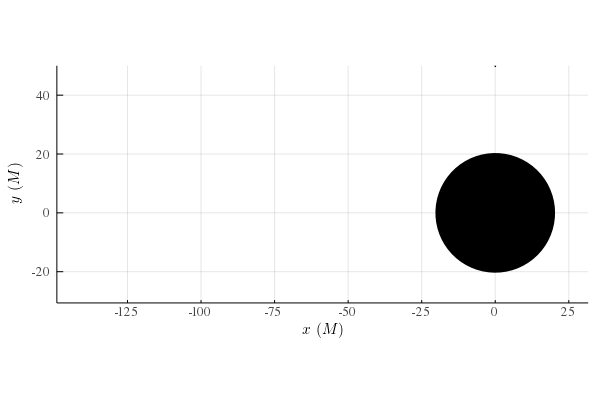

In [20]:
M = 10
a = 0.0
ϵ = 0.5
n = 3 # número de vueltas
b = 3*sqrt(3)*M + 3.4823*M*exp(-2*n*π)
ℓ = ϵ*b

p = [M, a, ϵ, b, ℓ]

r0 = 5*M
ϕ0 = π/2

λ_final = 1000.0
dλ = 1e-2

@time xs, ys, rs, ds = geodesics_kerr(p, r0, ϕ0, λ_final, dλ);

@show maximum(abs.(ds))

animate_trajectory(xs, ys, "Animations/n3.gif")

Pero cambiando $a$ suceden distintas cosas.

  0.066205 seconds (500.59 k allocations: 56.028 MiB)
maximum(abs.(ds)) = 5.33514205036667e-15


┌ Info: Saved animation to 
│   fn = /home/david/Documentos/Física/Servicio/Servicio-Github/Notebooks/Kerr/Animations/n3.gif
└ @ Plots /home/david/.julia/packages/Plots/qZHsp/src/animation.jl:98


Plots.AnimatedGif("/home/david/Documentos/Física/Servicio/Servicio-Github/Notebooks/Kerr/Animations/n3.gif")
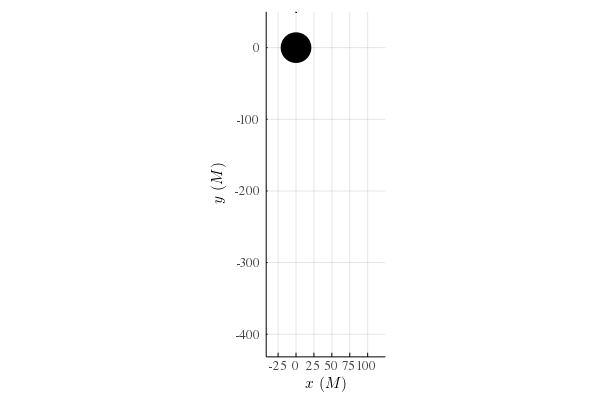

In [54]:
M = 10.0
a = 5.0
ϵ = 0.5
n = 3 # número de vueltas
b = 3*sqrt(3)*M + 3.4823*M*exp(-2*n*π)
ℓ = ϵ*b

p = [M, a, ϵ, b, ℓ]

r0 = 5*M
ϕ0 = π/2

λ_final = 1000.0
dλ = 1e-2

@time xs, ys, rs, ds = geodesics_kerr(p, r0, ϕ0, λ_final, dλ);

@show maximum(abs.(ds))

animate_trajectory(xs, ys, "Animations/n3.gif")

# Sombra

In [28]:
function ξ(r, M, a)    
    Δ = r^2- 2M*r + a^2     
    return ((r^2 - a^2)*M - Δ*r)/(a*(r-M))   
end

function η(r, M, a)    
    Δ = r^2- 2M*r + a^2     
    return (r^3*(4*M*Δ - r*(r-M)^2))/(a^2*(r-M)^2)
end

α(r, M, a, θ₀) = -ξ(r, M, a)*csc(θ₀)

function β(r, M, a, θ₀)   
    x = (sqrt(Complex(η(r, M, a) + (a*cos(θ₀))^2 - (ξ(r, M, a)*cot(θ₀))^2)))
    
    if imag(x) != 0.0
        return NaN
    else
        return abs(x)
    end    
end

β (generic function with 1 method)

In [29]:
function sombra(M, a, θ₀; Δr=a*0.0001)    
    # Entre más pequeño es a más Nan salen, por lo que es conveniente tomar Δr ~ a.    
    rs = M:Δr:5M
    
    αs = [α(rs[i], M, a, θ₀) for i in 1:length(rs) if !isnan(β(rs[i], M, a, θ₀))]
    βs = [β(rs[i], M, a, θ₀) for i in 1:length(rs) if !isnan(β(rs[i], M, a, θ₀))]
    
    # Concatenamos y unimos
    αs = vcat(αs, reverse(αs), αs[1:1])
    βs = vcat(βs, -reverse(βs), βs[1:1])
    
    shadow = plot(legend = false, aspect_ratio = 1, xlab = L"\alpha \ (M)", ylab = L"\beta \ (M)", 
                  fontfamily="Times")
    shadow = plot!(αs, βs, color = "black")
        
    return shadow
end 

sombra (generic function with 1 method)

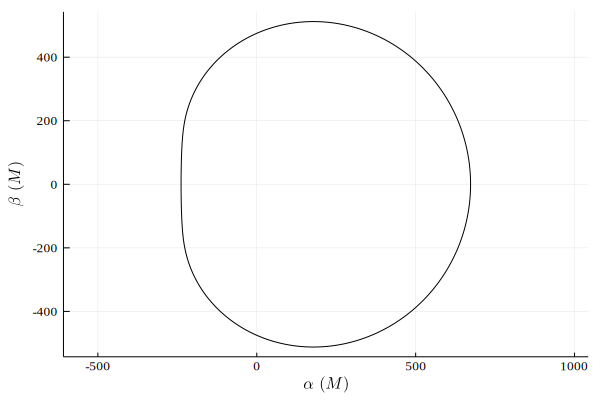

In [48]:
M = 100.0
a = 99.9
θ₀ = π/3

sombra(M, a, θ₀)